<a href="https://colab.research.google.com/github/shucream/colab_unet/blob/master/unet_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

U-netをTensor Flowのkerasで実装


# GoogleDriveの認証
モデルと重みをDriveに保存するため


In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Import

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


# データセット


## ダウンロード

In [0]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz > /dev/null && tar -xvzf annotations.tar.gz > /dev/null

# images/のファイル一覧を用いるので不要なファイルを削除
!rm  images/*.mat

--2020-05-30 14:14:56--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  73.4MB/s    in 11s     

2020-05-30 14:15:07 (69.6 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2020-05-30 14:15:08--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  63.7MB/s    in 0.3s    

2020-05-30 14:15:09 (63.7 MB/s)

## 画像の表示

In [0]:
# pic(255,255,3) mask(256, 256)
def show_image(pic, mask):
  mask = np.stack((mask,)*3, axis=-1)

  plt.axis('off')
  plt.imshow( np.concatenate([pic, mask, pic*mask], axis = 1))
  plt.show()

In [0]:
# pic(255,255,3) true(256, 256) mask(256, 256)
def show_data(pic, true, mask):
  diff = np.stack([true, mask, mask], axis=-1)
  true = np.stack((true,)*3, axis=-1)
  mask = np.stack((mask,)*3, axis=-1)

  plt.axis('off')
  line1 = np.concatenate([pic, mask, pic*mask], axis = 1)
  p_mask = mask
  p_mask[mask >= 0.5] = 1
  p_mask[mask < 0.5] = 0
  p_diff = np.stack([true, p_mask, p_mask], axis=-1)
  line2 = np.concatenate([pic, p_mask, pic*p_mask], axis = 1)
  line3 = np.concatenate([pic, true, pic*true], axis = 1)
  plt.imshow(np.concatenate([line1, line2, line3], axis = 0))
  plt.show()

In [0]:
def get_data(file_name):
  raw_image = Image.open(f'images/{file_name}').resize(size)
  raw = np.array(raw_image)
  raw = raw/255.

  mask_image = Image.open(f'annotations/trimaps/{file_name[:-4]}.png').resize(size)
  mask = np.array(mask_image)/3.

  return [raw, mask]

### サンプルコード

In [0]:
size = (256, 256)

all_files = os.listdir('images')
random_file = random.choice(all_files)

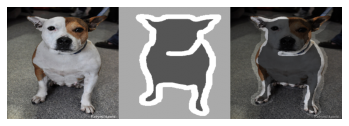

In [0]:
raw, mask = get_data(random_file)
show_image(raw, mask)

## データセットの切り分け

In [0]:
# 画像データをバッチで返すジェネレータ関数
# yeild (image1[batch_size], image2[batch_size])
def image_batch_generator(image_file_names, batch_size = 32, sz = (256, 256)):
  while True:
    files_batch = np.random.choice(image_file_names, size = batch_size)
    x_batch = []
    y_batch = []

    for file_name in files_batch:
      pic_data, mask_data = get_data(file_name)
      # picture(/images/)の画像の取得と正規化

      if len(pic_data.shape) == 2: # 白黒画像のときは3層重ねてrgbに拡張
        normalized_pic_data = np.stack((pic_data,)*3, axis=-1)
      else:
        normalized_pic_data = pic_data[:,:,0:3] # rgb3層のみにスライス(透明度とかを破棄)

      # mask(/annoations/trimaps/)の画像の取得と正規化

      mask_data[mask_data >= 0.4] = 0 # 2以上の境界と背景を0
      mask_data[mask_data != 0] = 1 # 残った対象を1
      normalized_mask_data = mask_data

      # batchに詰める
      x_batch.append(normalized_pic_data)
      y_batch.append(normalized_mask_data)

    x_batch = np.array(x_batch)
    y_batch = np.expand_dims(y_batch, 3)
    yield (x_batch, y_batch)

all_filesの画像を学習用、検証用、テスト用で分割

In [0]:
batch_size = 32

all_files = os.listdir('images')
shuffle(all_files)

# 仕切り
train_split = int(0.90 * len(all_files))
validation_split = train_split + int(0.05 * len(all_files))

# ファイル名を分割
train_files = all_files[0:train_split]
validation_files = all_files[train_split:validation_split]
test_files = all_files[validation_split:]

# ジェネレータ―にセット
train_generator = image_batch_generator(train_files, batch_size=batch_size)
validation_generator  = image_batch_generator(validation_files, batch_size=batch_size)
test_generator  = image_batch_generator(test_files, batch_size=batch_size)

### サンプルコード

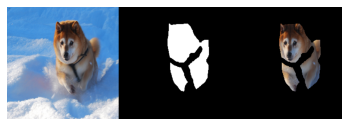

train_image_size:  6651
valid_image_size:  369
test_image_size:  370


In [0]:
x, y= next(train_generator)
show_image(x[0], y[0].squeeze())

print('train_image_size: ', len(train_files))
print('valid_image_size: ', len(validation_files))
print('test_image_size: ', len(test_files))

# 評価関数IoU

In [0]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# モデル
U-net


In [0]:
# U-Netの設計
# UNetを生成
def create_unet(sz=(256, 256, 3)):
  # input
  x = Input(sz)
  inputs = x

  # down sampling
  f = 8 # filter_num
  kernel_size = 3

  layers = []

  for i in range(0,6):
    x = Conv2D(f, kernel_size, activation='relu', padding='same') (x)
    x = Conv2D(f, kernel_size, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2

  # up sampling
  transpose_f = 64
  transpose_kernel_size = 2

  for i in range(0, 6):
    x = Conv2D(f, kernel_size, activation='relu', padding='same') (x)
    x = Conv2D(f, kernel_size, activation='relu', padding='same') (x)
    x = Conv2DTranspose(transpose_f, transpose_kernel_size, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[-(i+1)]])
    f = f // 2
    transpose_f = transpose_f // 2

  # classification
  x = Conv2D(f, kernel_size, activation='relu', padding='same') (x)
  x = Conv2D(f, kernel_size, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)

  # モデルの生成
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])

  return model

In [0]:
model = create_unet()

# Callback

In [0]:
def predict(x, true):
  pred = model.predict(np.expand_dims(x, 0))
  show_data(x, true.squeeze(), pred.squeeze())


In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        x_batch, true_batch= next(test_generator)
        predict(x_batch[0], true_batch[0])
        
        

# 学習

Epoch 1/30
207/207 [==============================] - 108s 520ms/step - loss: 0.5527 - mean_iou: 0.1453 - val_loss: 0.4845 - val_mean_iou: 0.4062
i= 1 loss= 0.5526718272679094 val_loss= 0.48451951146125793 mean_iou= 0.14531706 val_mean_iou= 0.4062466621398926


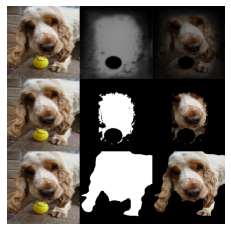

Epoch 2/30
207/207 [==============================] - 100s 483ms/step - loss: 0.4545 - mean_iou: 0.4364 - val_loss: 0.4338 - val_mean_iou: 0.4856
i= 2 loss= 0.4545001548845411 val_loss= 0.4337507486343384 mean_iou= 0.43644384 val_mean_iou= 0.48564815521240234


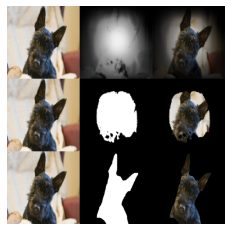

Epoch 3/30
207/207 [==============================] - 102s 494ms/step - loss: 0.4317 - mean_iou: 0.4687 - val_loss: 0.3724 - val_mean_iou: 0.4611
i= 3 loss= 0.4316973226945757 val_loss= 0.3723733425140381 mean_iou= 0.46865645 val_mean_iou= 0.4610929787158966


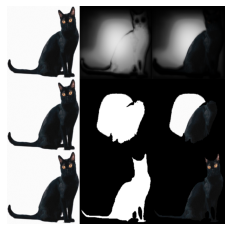

Epoch 4/30
207/207 [==============================] - 101s 488ms/step - loss: 0.4106 - mean_iou: 0.4936 - val_loss: 0.3998 - val_mean_iou: 0.5399
i= 4 loss= 0.41055811531301856 val_loss= 0.39976373314857483 mean_iou= 0.49355114 val_mean_iou= 0.5398670434951782


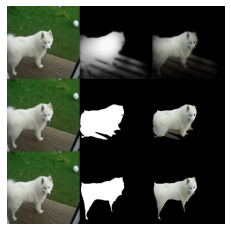

Epoch 5/30
207/207 [==============================] - 102s 494ms/step - loss: 0.3727 - mean_iou: 0.5426 - val_loss: 0.3377 - val_mean_iou: 0.5718
i= 5 loss= 0.37268363292090556 val_loss= 0.3376848101615906 mean_iou= 0.5425906 val_mean_iou= 0.571844220161438


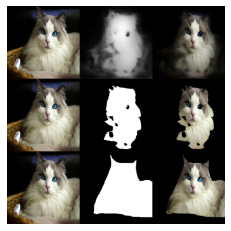

Epoch 6/30
207/207 [==============================] - 101s 488ms/step - loss: 0.3278 - mean_iou: 0.6045 - val_loss: 0.3410 - val_mean_iou: 0.5831
i= 6 loss= 0.3278446882099345 val_loss= 0.3410397171974182 mean_iou= 0.60450053 val_mean_iou= 0.5830609798431396


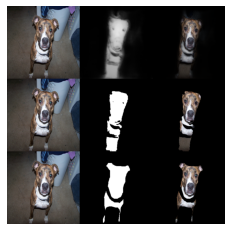

Epoch 7/30
207/207 [==============================] - 100s 484ms/step - loss: 0.2942 - mean_iou: 0.6539 - val_loss: 0.4316 - val_mean_iou: 0.6056
i= 7 loss= 0.29415018136662563 val_loss= 0.43157121539115906 mean_iou= 0.6538902 val_mean_iou= 0.605554461479187


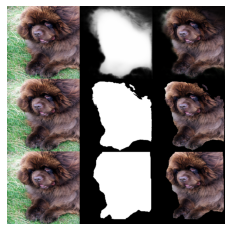

Epoch 8/30
207/207 [==============================] - 100s 485ms/step - loss: 0.2695 - mean_iou: 0.6805 - val_loss: 0.2833 - val_mean_iou: 0.6544
i= 8 loss= 0.2694898986298105 val_loss= 0.2832542657852173 mean_iou= 0.68051416 val_mean_iou= 0.6544430255889893


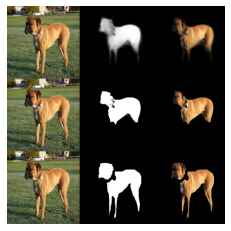

Epoch 9/30
138/207 [===================>..........] - ETA: 32s - loss: 0.2556 - mean_iou: 0.6980

In [0]:
train_steps = len(train_files) // batch_size
validation_steps = len(validation_files) // batch_size
model.fit_generator(
    train_generator, 
    epochs = 30, 
    steps_per_epoch = train_steps,
    validation_data = validation_generator, 
    validation_steps = validation_steps,
    verbose = 1,
    callbacks = build_callbacks(),
  )

# テスト


In [0]:
x_batch, true_batch= next(test_generator)

for i in range(batch_size):
  predict(x_batch[i], true_batch[i])
  

In [0]:
print(iou.shape)

# モデルの保存


In [0]:
# フォルダ指定
folder_id = drive.ListFile({'q': 'title = "unet_dog"'}).GetList()[0]['id']

# modelのJSON化
model_json = model.to_json()
with open("model.json", "w") as f:
  f.write(model_json)

# 重みの保存
model.save_weights('param.hdf5')

upload_file = drive.CreateFile({"parents": [{"id": folder_id}]})
upload_file.SetContentFile("model.json")
upload_file.Upload()

upload_file = drive.CreateFile({"parents": [{"id": folder_id}]})
upload_file.SetContentFile("param.hdf5")
upload_file.Upload()